<a href="https://colab.research.google.com/github/iamhero2709/Learning-Projects-Notebook/blob/main/tensorflow_withdl/RBN_tensorfllow7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting RBM training...
Epoch 0/50, Reconstruction Error: 0.2507
Epoch 10/50, Reconstruction Error: 0.2484
Epoch 20/50, Reconstruction Error: 0.2470
Epoch 30/50, Reconstruction Error: 0.2450
Epoch 40/50, Reconstruction Error: 0.2401
Training finished.

--- Reconstruction Example ---
Original Data Point (first 20 values):
[1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]

Reconstructed Data Point (first 20 values):
[1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.]


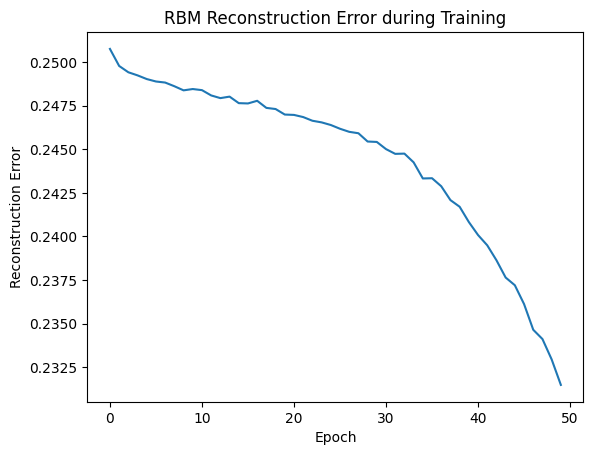

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# --- 1. RBM Parameters ---
num_visible = 784  # For example, if we were training on MNIST images (28x28 = 784 pixels)
num_hidden = 128   # Number of hidden units (a hyperparameter you can tune)
learning_rate = 0.01
k = 1              # Number of Gibbs sampling steps for Contrastive Divergence (CD-k)
epochs = 50        # Number of training iterations
batch_size = 10 # Define a batch size

# --- 2. RBM Components in TensorFlow 2.x ---

# Use tf.Variable for weights and biases
W = tf.Variable(tf.random.normal([num_visible, num_hidden], mean=0.0, stddev=0.01), name="weights")
a = tf.Variable(tf.zeros([num_visible]), name="visible_biases")
b = tf.Variable(tf.zeros([num_hidden]), name="hidden_biases")

# --- 3. Core RBM Operations in TensorFlow 2.x ---

# Function to sample from a Bernoulli distribution (0 or 1 based on probability)
@tf.function # Use tf.function for graph mode execution
def sample_bernoulli(probs):
    return tf.floor(probs + tf.random.uniform(tf.shape(probs), 0, 1))

# Function for one step of Gibbs sampling (Positive and Negative Phase combined for CD-1)
@tf.function
def gibbs_step(v):
    # Positive Phase (data-driven)
    hidden_probs = tf.nn.sigmoid(tf.matmul(v, W) + b)
    hidden_state = sample_bernoulli(hidden_probs)

    # Negative Phase (reconstruction)
    visible_reconstruction_probs = tf.nn.sigmoid(tf.matmul(hidden_state, tf.transpose(W)) + a)
    visible_reconstruction_state = sample_bernoulli(visible_reconstruction_probs)

    return hidden_probs, hidden_state, visible_reconstruction_probs, visible_reconstruction_state

# Function to compute reconstruction error
@tf.function
def compute_reconstruction_error(v, visible_reconstruction_probs):
    return tf.reduce_mean(tf.square(v - visible_reconstruction_probs))

# --- 4. Training Loop ---

# For demonstration, let's create some simple synthetic binary data
sample_data = np.random.randint(0, 2, size=(100, num_visible)).astype(np.float32)

# Create a TensorFlow Dataset for batching
dataset = tf.data.Dataset.from_tensor_slices(sample_data).batch(batch_size)

# Use GradientTape for automatic differentiation
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)

print("Starting RBM training...")
errors = []

for epoch in range(epochs):
    epoch_errors = []
    for batch_data in dataset:
        with tf.GradientTape() as tape:
            # Perform a Gibbs step
            hidden_probs, hidden_state, visible_reconstruction_probs, visible_reconstruction_state = gibbs_step(batch_data)

            # Calculate reconstruction error for the batch
            error = compute_reconstruction_error(batch_data, visible_reconstruction_probs)
            epoch_errors.append(error.numpy()) # Collect error as numpy value

            # Calculate gradients for CD-1
            # The gradients are based on the difference between positive and negative phase expectations
            # Positive associations: <v_0 h_0>
            positive_association = tf.matmul(tf.transpose(batch_data), hidden_probs)
            # Negative associations: <v_1 h_1>
            # Need to compute h_1 based on v_1 (visible_reconstruction_state)
            hidden_probs_recon = tf.nn.sigmoid(tf.matmul(visible_reconstruction_state, W) + b)
            negative_association = tf.matmul(tf.transpose(visible_reconstruction_state), hidden_probs_recon)

            # Gradients
            dW = (positive_association - negative_association) / tf.cast(tf.shape(batch_data)[0], tf.float32)
            da = tf.reduce_mean(batch_data - visible_reconstruction_state, axis=0)
            db = tf.reduce_mean(hidden_probs - hidden_probs_recon, axis=0)

            # Apply gradients manually (as we are not using a standard Keras model)
            # This is equivalent to optimizer.apply_gradients([(dW, W), (da, a), (db, b)]) but calculated manually
            W.assign_add(learning_rate * dW)
            a.assign_add(learning_rate * da)
            b.assign_add(learning_rate * db)


    # Calculate average error for the epoch
    avg_epoch_error = np.mean(epoch_errors)
    errors.append(avg_epoch_error)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Reconstruction Error: {avg_epoch_error:.4f}")

print("Training finished.")

# --- After Training: Reconstruction Example ---
# Let's try to reconstruct some original data point
test_data_point = sample_data[0:1] # Take the first sample from our data

# Get the hidden probabilities and state for this test data
hidden_probs_test, hidden_state_test, _, _ = gibbs_step(test_data_point)

# Reconstruct the visible data from the sampled hidden state
# Need to run the reconstruction step again with the sampled hidden state
reconstructed_visible_probs = tf.nn.sigmoid(tf.matmul(hidden_state_test, tf.transpose(W)) + a)
reconstructed_visible_state = sample_bernoulli(reconstructed_visible_probs)


print("\n--- Reconstruction Example ---")
print("Original Data Point (first 20 values):")
print(test_data_point[0, :20])
print("\nReconstructed Data Point (first 20 values):")
print(reconstructed_visible_state[0, :20].numpy())


# Plotting the reconstruction error over epochs
plt.plot(errors)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.title("RBM Reconstruction Error during Training")
plt.show()

In [5]:
import urllib.request
with urllib.request.urlopen("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week4/data/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

In [6]:
import numpy as np
import tensorflow as tf
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
v_bias=tf.Variable(tf.zeros([7]),tf.float32) # bias for the 7 variable units
h_bias=tf.  Variable(tf.zeros([2]),tf.float32) # bias for the 2 hidden units


In [13]:
# defining weight
W = tf.constant(np.random.normal(loc=0.0, scale=1.0, size=(7, 2)).astype(np.float32))

In [14]:
# the inference pass
# single forwar pass
# single backward pass
# predefined input vector
X=tf.constant([[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]],tf.float32)
v_state=X # current state of the visible layer
print("Input:",v_state)

Input: tf.Tensor([[1. 0. 0. 1. 0. 0. 0.]], shape=(1, 7), dtype=float32)


In [16]:
# forward pass
# calculating h_prob and h_state
h_bias=tf.constant([0.1, 0.1]) # using a fixed h_bias for this demo with correct shape
# calculating the probalities of turning the hidden units on:
h_prob=tf.nn.sigmoid(tf.matmul(v_state,W)+ h_bias) # probalieties of hidden units
print("probalities of hidden units p(h|v):",h_prob)

# drawing samples from the distribution
h_state=tf.nn.relu(tf.sign(h_prob-tf.random.uniform(tf.shape(h_prob)))) # states
print("h0 states",h_state)

probalities of hidden units p(h|v): tf.Tensor([[0.87608814 0.30364704]], shape=(1, 2), dtype=float32)
h0 states tf.Tensor([[1. 0.]], shape=(1, 2), dtype=float32)


In [17]:
# backward pass
# calcul;ating v_prob and v_state
vb = tf.constant([0.1, 0.2, 0.1, 0.1, 0.1, 0.2, 0.1]) # Using a fixed v_bias for this demo
print("b:",vb)
v_prob=tf.nn.sigmoid(tf.matmul(h_state,tf.transpose(W))+vb) # probalities of the visble units
print ("p(vi∣h): ", v_prob)
v_state = tf.nn.relu(tf.sign(v_prob - tf.random.uniform(tf.shape(v_prob)))) # states
print ("v probability states: ", v_state)

b: tf.Tensor([0.1 0.2 0.1 0.1 0.1 0.2 0.1], shape=(7,), dtype=float32)
p(vi∣h):  tf.Tensor(
[[0.54068506 0.413943   0.3644832  0.8690739  0.8921782  0.87624085
  0.32634065]], shape=(1, 7), dtype=float32)
v probability states:  tf.Tensor([[1. 0. 0. 1. 1. 0. 0.]], shape=(1, 7), dtype=float32)


In [18]:
# calcuating the probalities of reconsutructions
# calutes the probalityu of original  input vector X given the reconstructed probalitues v_prob
inp=X
print("input X :",inp.numpy())
print("probablity vector: ", v_prob[0].numpy())
v_probability = 1
for elm, p in zip(inp[0],v_prob[0]) :
    if elm ==1:
        v_probability *= p
    else:
        v_probability *= (1-p)

print("probability of generating X: " , v_probability.numpy())

input X : [[1. 0. 0. 1. 0. 0. 0.]]
probablity vector:  [0.54068506 0.413943   0.3644832  0.8690739  0.8921782  0.87624085
 0.32634065]
probability of generating X:  0.0015732304


MNIST DATASET LOADING AND RBM INTAILIZATION FOR TRAINING
----

In [20]:
# LOADING TRAINING AND TEST DATA
mnist=tf.keras.datasets.mnist
(trX,trY),(teX,teY)=mnist.load_data()

# showing an example of the flatten class and operation
from tensorflow.keras.layers import Flatten
flatten=Flatten(dtype='float32')
trX=flatten(trX/255.0)
trY = flatten(trY/255.0) # Note: trY is not strictly needed for unsupervised RBM training, but loaded with the dataset.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# rbm dimension for mnist
# mnist images have 784 pixels so  the visible layers mus have 784 inputs nodes
# for our case we will use 50 nodes in the hidden layers  so i =50
vb = tf.Variable(tf.zeros([784]), tf.float32) # Visible biases for 784 pixels
hb = tf.Variable(tf.zeros([50]), tf.float32)  # Hidden biases for 50 hidden units
W = tf.Variable(tf.zeros([784,50]), tf.float32) # Weights connecting 784 visible to 50 hidden units

In [22]:
# defining RBM operations as functions
# encapuslates the forward and backward pass
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_X
    return h0_state

In [23]:
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) # probabilities of the visible units
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0] # Returns a 1D vector

In [24]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

In [25]:
# training
# parameters
#Parameters
alpha = 0.01 # learning rate
epochs = 1
batchsize = 200
weights = []
errors = []
batch_number = 0
K = 1 # CD-1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((trX, trY)).batch(batchsize)

In [26]:
# training loop
for epoch in range(epochs):
    for batch_x, batch_y in train_ds: # batch_y is ignored as RBM is unsupervised
        batch_number += 1
        for i_sample in range(batchsize):
            # CD-K loop (K=1 here)
            for k in range(K):
                v0_state = batch_x[i_sample] # Original input (v_0)
                h0_state = hidden_layer(v0_state, W, hb) # Hidden state from v_0 (h_0)
                v1_state = reconstructed_output(h0_state, W, vb) # Reconstructed visible state (v_1)
                h1_state = hidden_layer(v1_state, W, hb) # Hidden state from v_1 (h_1)

                # Update Weights and Biases using CD-1
                # delta_W = (v_0 * h_0^T) - (v_1 * h_1^T)
                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                # Bias updates
                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0)

                v0_state = v1_state # For CD-k (if k>1), the v_state for next step is current v_1
                                    # Not strictly needed for K=1 if the update is only based on v_0 and v_1
                                    # but maintains the general CD process.

            # Report error at end of batch
            if i_sample == batchsize-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W) # Store weights (though usually only final weights are stored)
                print ( 'Epoch: %d' % epoch,
                       "batch #: %i " % batch_number, "of %i" % int(60e3/batchsize),
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)

Epoch: 0 batch #: 1  of 300 sample #: 199 reconstruction error: 0.156105
Epoch: 0 batch #: 2  of 300 sample #: 199 reconstruction error: 0.240129
Epoch: 0 batch #: 3  of 300 sample #: 199 reconstruction error: 0.109090
Epoch: 0 batch #: 4  of 300 sample #: 199 reconstruction error: 0.097805
Epoch: 0 batch #: 5  of 300 sample #: 199 reconstruction error: 0.105005
Epoch: 0 batch #: 6  of 300 sample #: 199 reconstruction error: 0.192871
Epoch: 0 batch #: 7  of 300 sample #: 199 reconstruction error: 0.081581
Epoch: 0 batch #: 8  of 300 sample #: 199 reconstruction error: 0.133895
Epoch: 0 batch #: 9  of 300 sample #: 199 reconstruction error: 0.096396
Epoch: 0 batch #: 10  of 300 sample #: 199 reconstruction error: 0.168308
Epoch: 0 batch #: 11  of 300 sample #: 199 reconstruction error: 0.088145
Epoch: 0 batch #: 12  of 300 sample #: 199 reconstruction error: 0.136851
Epoch: 0 batch #: 13  of 300 sample #: 199 reconstruction error: 0.076453
Epoch: 0 batch #: 14  of 300 sample #: 199 reco

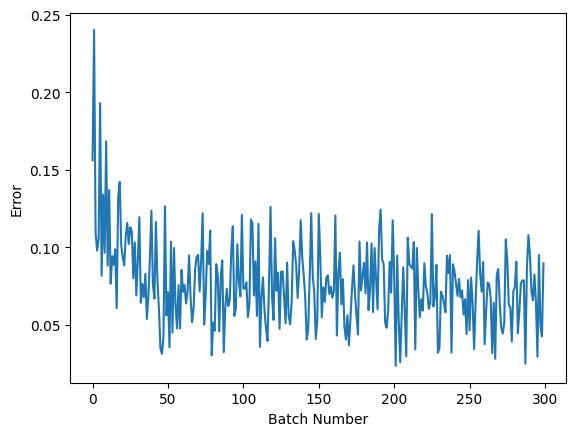

In [27]:
# errro plotting
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

array([[145, 143, 146, ...,  78,  73,  75],
       [146, 149, 143, ...,  73,  73,  74],
       [148, 149, 148, ...,  73,  71,  73],
       ...,
       [ 78,  79,  80, ...,  49,  48,  50],
       [ 84,  80,  79, ...,  46,  48,  47],
       [ 81,  78,  83, ...,  44,  50,  47]], dtype=uint8)
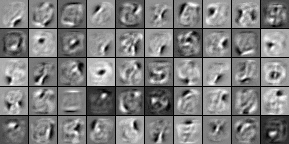

In [28]:
# learned feature and reconsutructions
tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
# ... (rest of plotting code)

utils.py loaded successfully.

--- Visualizing Learned Features (Weights) ---


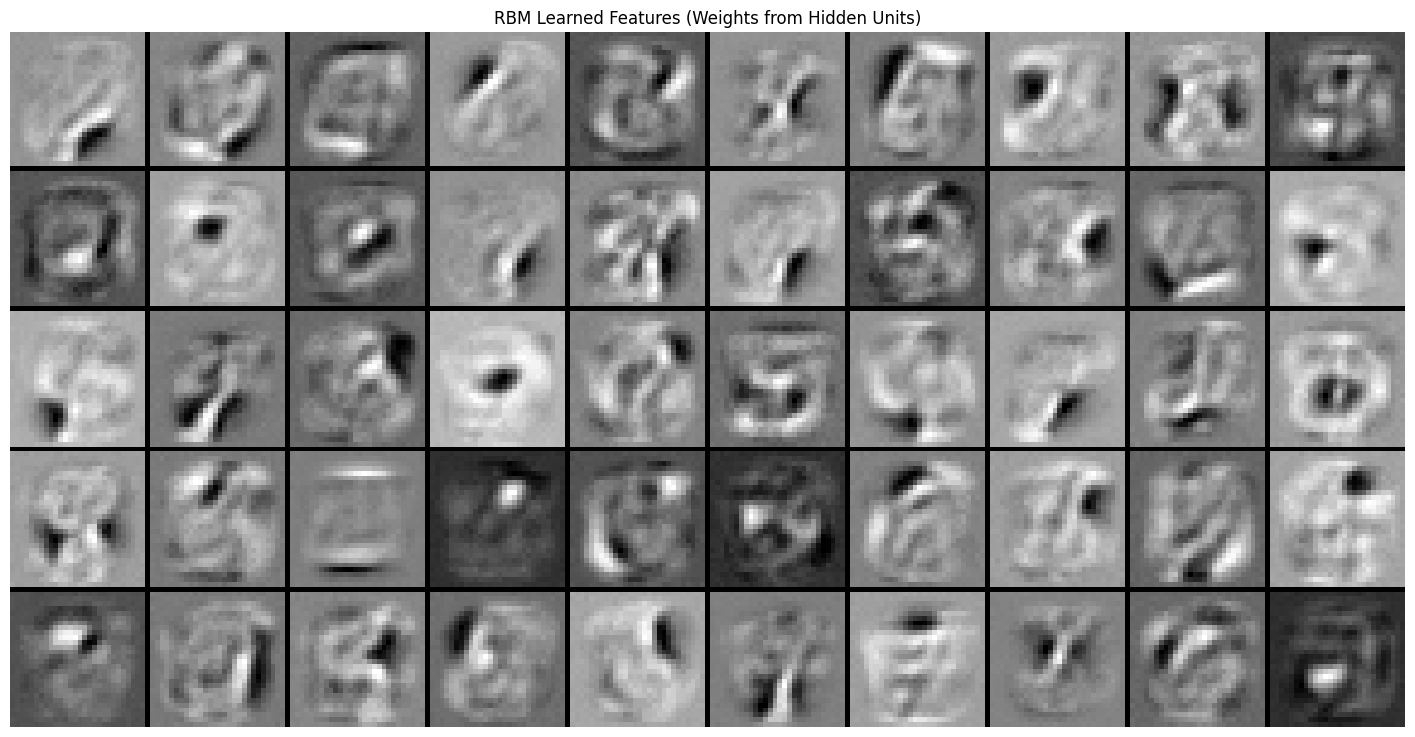

Each tile above corresponds to the weight connections of a single hidden unit to all visible units.
Whiter pixels indicate more positive weights, darker pixels indicate more negative weights.
These visualizations show the 'patterns' or 'features' that each hidden unit has learned to detect.

--- Visualizing a Single Learned Feature (e.g., Hidden Unit 10) ---


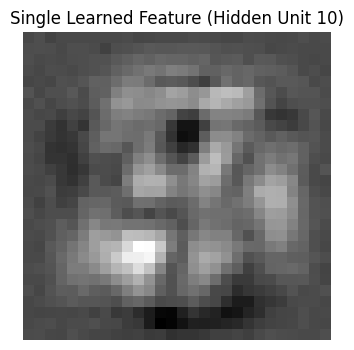

This single tile shows the specific visual pattern that hidden unit 10 is most sensitive to.

--- Image Reconstruction Demonstration ---
We'll take a 'destructed' image and see if the trained RBM can reconstruct a cleaner version.
--2025-07-18 03:59:47--  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Resolving ibm.box.com (ibm.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to ibm.box.com (ibm.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2025-07-18 03:59:47--  https://ibm.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
Reusing existing connection to ibm.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg [following]
--2025-07-18 03:59:47--  https://ibm.ent.box.com/public/static/vvm1b63uvuxq88vbw9znpw

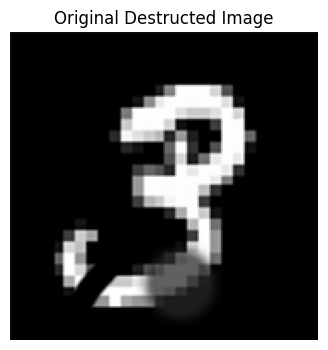


--- Processing and Reconstructing the Image ---
Probability nodes in hidden layer: [[1.59568790e-05 9.99998927e-01 1.00000000e+00 1.14882504e-09
  1.71674322e-02 3.22615795e-10 9.99548852e-01 9.99948680e-01
  1.15341158e-03 9.99971867e-01 7.41586490e-08 1.02073379e-01
  9.99986351e-01 1.41913816e-01 3.09674651e-03 1.01029315e-11
  9.97959912e-01 1.00000000e+00 2.18845205e-03 9.98381138e-01
  2.13958767e-10 2.76835693e-10 9.99750376e-01 4.67238801e-18
  2.14792075e-04 9.98639524e-01 6.76492334e-11 2.55880993e-12
  4.28069917e-08 9.17316938e-05 9.99942541e-01 8.59564775e-09
  9.12716942e-08 9.99996662e-01 1.00000000e+00 3.62875668e-04
  7.21944988e-01 2.21395142e-11 2.77999252e-01 4.27402471e-13
  9.99998569e-01 8.67261887e-01 2.03859563e-05 9.98365700e-01
  1.79245632e-16 1.62958856e-14 6.91346232e-13 8.74016051e-12
  3.34077158e-05 1.43085736e-05]]
Activated nodes in hidden layer: [[0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 1.

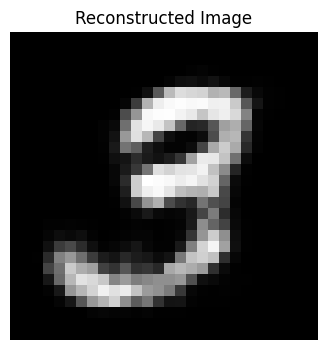


Observation: If the RBM was trained well, the reconstructed image should appear less noisy or closer to a clear digit than the original destructed input, demonstrating the RBM's ability to 'denoise' or 'complete' patterns based on its learned distribution.


In [29]:
# --- Learned Features and Reconstructions ---

# Load a utility file that contains 'tile_raster_images' function.
# This part is typically done at the beginning of the notebook, but included here for completeness
import urllib.request
try:
    with urllib.request.urlopen("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week4/data/utils.py") as url:
        response = url.read()
    target = open('utils.py', 'w')
    target.write(response.decode('utf-8'))
    target.close()
    from utils import tile_raster_images
    print("utils.py loaded successfully.")
except Exception as e:
    print(f"Error loading utils.py: {e}. Please ensure you have internet access or the file is present.")
    # Fallback/placeholder for tile_raster_images if download fails (for local testing)
    def tile_raster_images(X, img_shape, tile_shape, tile_spacing=(0, 0),
                           scale_rows_to_unit_interval=True,
                           output_pixel_vals=True):
        """
        Dummy tile_raster_images for local execution without network if utils.py fails.
        In a real scenario, you'd want the actual function.
        """
        print("Warning: Using dummy tile_raster_images. Visualizations might not work.")
        # Create a blank image based on tile_shape and img_shape for basic functionality
        out_rows = tile_shape[0] * (img_shape[0] + tile_spacing[0]) - tile_spacing[0]
        out_cols = tile_shape[1] * (img_shape[1] + tile_spacing[1]) - tile_spacing[1]
        return np.zeros((out_rows, out_cols))


import matplotlib.pyplot as plt
from PIL import Image
# %matplotlib inline is typically run at the top of the notebook.
# It ensures plots appear inline in Jupyter/IPython.

print("\n--- Visualizing Learned Features (Weights) ---")
# tile_raster_images transforms the weight matrix (W.numpy().T)
# where each row is a flattened image (784 pixels), into an array
# that can be visualized as tiles (e.g., 5 rows, 10 columns of 28x28 images).
# The W matrix has shape (num_visible, num_hidden) -> (784, 50).
# We need to transpose it (W.T) to get (50, 784) so each row corresponds to a hidden unit's weights.
image = Image.fromarray(tile_raster_images(X=W.numpy().T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1)))

# Plot the image of all learned features
plt.rcParams['figure.figsize'] = (18.0, 18.0) # Set figure size for better visibility
imgplot = plt.imshow(image)
imgplot.set_cmap('gray') # Set colormap to grayscale
plt.title("RBM Learned Features (Weights from Hidden Units)")
plt.axis('off') # Hide axes
plt.show()

print("Each tile above corresponds to the weight connections of a single hidden unit to all visible units.")
print("Whiter pixels indicate more positive weights, darker pixels indicate more negative weights.")
print("These visualizations show the 'patterns' or 'features' that each hidden unit has learned to detect.")


print("\n--- Visualizing a Single Learned Feature (e.g., Hidden Unit 10) ---")
# To visualize just one hidden unit's weights (e.g., the 10th one, which is index 9)
# W.numpy().T[10:11] selects the 10th row (corresponding to the 10th hidden unit)
# and keeps it as a 2D array
image_single_feature = Image.fromarray(tile_raster_images(X =W.numpy().T[9:10], img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))

# Plot the single feature
plt.rcParams['figure.figsize'] = (4.0, 4.0) # Adjust figure size for a single image
imgplot_single = plt.imshow(image_single_feature)
imgplot_single.set_cmap('gray') # Set colormap to grayscale
plt.title("Single Learned Feature (Hidden Unit 10)")
plt.axis('off') # Hide axes
plt.show()

print("This single tile shows the specific visual pattern that hidden unit 10 is most sensitive to.")


print("\n--- Image Reconstruction Demonstration ---")
print("We'll take a 'destructed' image and see if the trained RBM can reconstruct a cleaner version.")

# 1. Download the destructed image if it's not present
import os
image_file = 'destructed3.jpg'
if not os.path.exists(image_file):
    print(f"Downloading {image_file}...")
    !wget -O {image_file} https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
    print("Download complete.")
else:
    print(f"{image_file} already exists.")

# 2. Load and display the destructed image
img_destructed = Image.open(image_file)
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.imshow(img_destructed)
plt.title("Original Destructed Image")
plt.axis('off')
plt.show()


# 3. Convert the image to a 1D numpy array and normalize
# 'I' converts to grayscale, resize to 28x28, ravel() flattens, reshape((1, -1)) makes it 2D array with 1 row
sample_case = np.array(img_destructed.convert('I').resize((28,28))).ravel().reshape((1, -1))/255.0
sample_case = tf.cast(sample_case, dtype=tf.float32) # Cast to TensorFlow float32 tensor

print("\n--- Processing and Reconstructing the Image ---")
# 4. Feed the sample case through the trained network (forward pass)
# Compute probabilities for hidden layer activation
hh0_p = tf.nn.sigmoid(tf.matmul(sample_case, W) + hb) # Probabilities of hidden units

# Sample binary hidden states (rounding to 0 or 1 for simplicity here, instead of stochastic sampling)
# Note: The original notebook uses tf.round() here, which is deterministic,
# while the training used tf.nn.relu(tf.sign(...)) for stochastic sampling.
# For inference/reconstruction demonstration, tf.round() is often used for a deterministic output.
hh0_s = tf.round(hh0_p) # Activated nodes in hidden layer

print("Probability nodes in hidden layer:", hh0_p.numpy())
print("Activated nodes in hidden layer:", hh0_s.numpy())

# 5. Reconstruct the visible layer from the sampled hidden states (backward pass)
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s, tf.transpose(W)) + vb) # Probabilities for reconstructed visible units
print("Probabilities for reconstructed visible layer:", vv1_p.numpy())

# 6. Plot the reconstructed image
# Use tile_raster_images to format the 1D reconstructed probability vector into a 28x28 image for display
img_reconstructed = Image.fromarray(tile_raster_images(X=vv1_p.numpy(), img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot_reconstructed = plt.imshow(img_reconstructed)
imgplot_reconstructed.set_cmap('gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()

print("\nObservation: If the RBM was trained well, the reconstructed image should appear less noisy or closer to a clear digit than the original destructed input, demonstrating the RBM's ability to 'denoise' or 'complete' patterns based on its learned distribution.")